# AdventureWorks2022 Analysis

The goal of this analysis is to provide an overview of the AdventureWorks2022 database, perform a statistical analysis including a confidence interval, and draw business-relevant conclusions.

In [ ]:
from sqlalchemy import create_engine, inspect
from scipy import stats 
import numpy as np                                             
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Function to create engine
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # SQL Server authentication  
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    # print(eng)
    return create_engine(eng)     
 
# Create engine and connection
engine = new_engine("mssql", "DESKTOP-B3C6BEO", "AdventureWorks2022", integrated_security=True)
connection = engine.connect()


In [179]:
# Load first rows from one table to verify connection
df = pd.read_sql(sql="SELECT * from Sales.Customer", con=connection)
df.head(5)

,CustomerID,PersonID,StoreID,TerritoryID,AccountNumber,rowguid,ModifiedDate
0,1,NaN,934.0,1,AW00000001,3F5AE95E-B87D-4AED-95B4-C3797AFCB74F,2014-09-12 11:15:07.263
1,2,NaN,1028.0,1,AW00000002,E552F657-A9AF-4A7D-A645-C429D6E02491,2014-09-12 11:15:07.263
2,3,NaN,642.0,4,AW00000003,130774B1-DB21-4EF3-98C8-C104BCD6ED6D,2014-09-12 11:15:07.263
3,4,NaN,932.0,4,AW00000004,FF862851-1DAA-4044-BE7C-3E85583C054D,2014-09-12 11:15:07.263
4,5,NaN,1026.0,4,AW00000005,83905BDC-6F5E-4F71-B162-C98DA069F38A,2014-09-12 11:15:07.263


---

## Exploring Database Structure

To understand the database contents, we list all schemas and tables.



In [201]:
inspector = inspect(engine)
all_schemas = inspector.get_schema_names()
schema_table_counts = []

for schema in all_schemas:
    if schema == 'dbo':  # hoppa över dbo
        continue
    tables = inspector.get_table_names(schema=schema)
    schema_table_counts.append({
        'Schema': schema,
        'Number of Tables': len(tables),
        'Has Tables': len(tables) > 0
    })

df_schema_counts = pd.DataFrame(schema_table_counts).sort_values(by='Number of Tables', ascending=False)

# Filtrera så att endast schemas med tabeller visas
df_schemas_with_tables = df_schema_counts[df_schema_counts['Has Tables'] == True].reset_index(drop=True)

df_schemas_with_tables


,Schema,Number of Tables,Has Tables
0,Production,25,True
1,Sales,19,True
2,Person,13,True
3,HumanResources,6,True
4,Purchasing,5,True


C:\Users\lenma\AppData\Local\Temp\ipykernel_17416\3800363522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_schemas_with_tables, x='Schema', y='Number of Tables', palette="viridis")


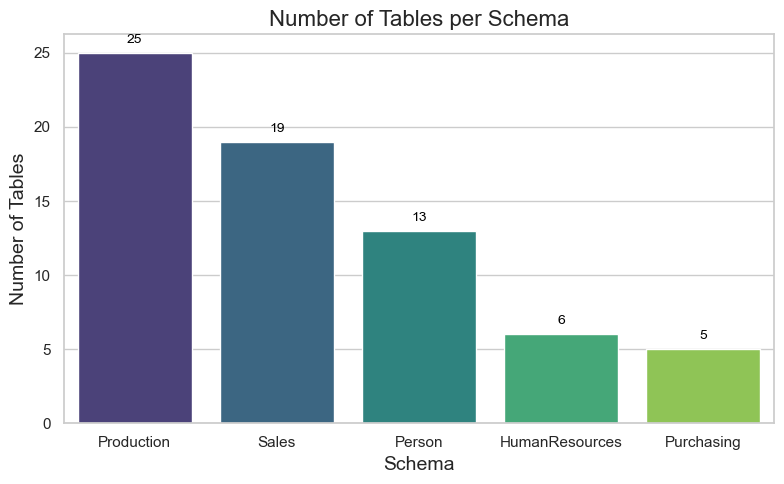

In [204]:
sns.set_theme(style="whitegrid")

# Filtrera bort 'dbo' om den finns kvar
df_filtered = df_schemas_with_tables[df_schemas_with_tables['Schema'] != 'dbo']

plt.figure(figsize=(8,5))
ax = sns.barplot(data=df_schemas_with_tables, x='Schema', y='Number of Tables', palette="viridis")

# Lägg till värden ovanför staplarna
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5),
                textcoords='offset points')

plt.title('Number of Tables per Schema', fontsize=16)
plt.xlabel('Schema', fontsize=14)
plt.ylabel('Number of Tables', fontsize=14)
plt.tight_layout()
plt.show()

In [214]:
# 1. Antal kunder
query_customers = "SELECT COUNT(*) AS CustomerCount FROM Sales.Customer"
df_customers = pd.read_sql(query_customers, engine)
print(f"Total number of customers: {df_customers['CustomerCount'].iloc[0]}")

Total number of customers: 19820


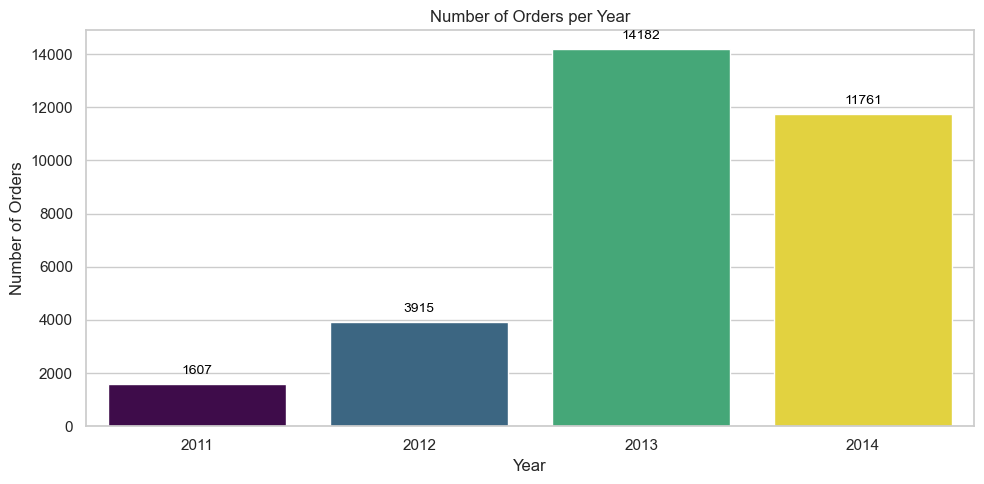

In [271]:
# 2. Antal ordrar per år (försäljning över tid)
query_orders_per_year = """
SELECT YEAR(OrderDate) AS Year, COUNT(SalesOrderID) AS NumberOfOrders
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""
df_orders_per_year = pd.read_sql(query_orders_per_year, engine)
# print(df_orders_per_year)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=df_orders_per_year, 
    x='Year', 
    y='NumberOfOrders', 
    hue='Year',          
    palette='viridis',
    legend=False
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5),
                textcoords='offset points')

plt.title('Number of Orders per Year')
plt.xlabel('Year')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

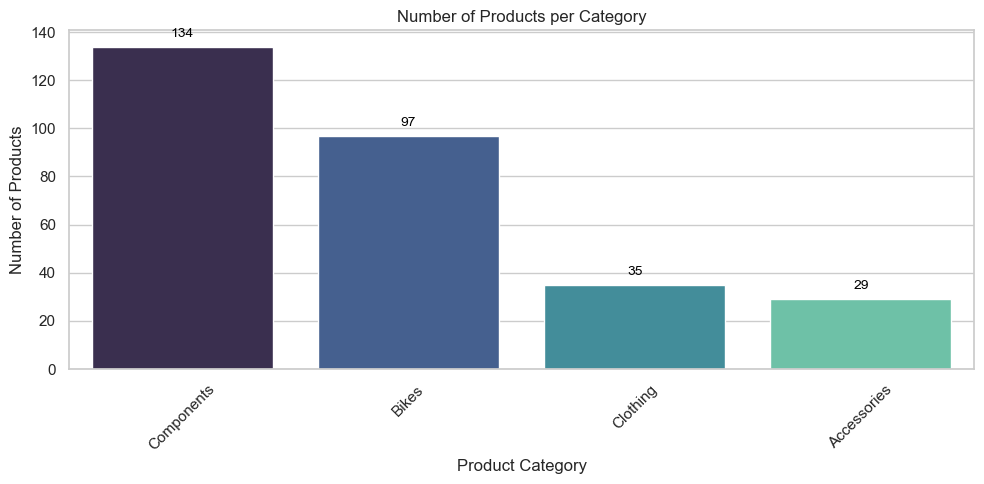

In [ ]:
# 3. Antal produkter per kategori
query_products_per_category = """
SELECT pc.Name AS CategoryName, COUNT(p.ProductID) AS ProductCount
FROM Production.Product p
JOIN Production.ProductSubcategory psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name;
"""

df_products_per_category = pd.read_sql(query_products_per_category, engine)
# print(df_products_per_category)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    data=df_products_per_category.sort_values('ProductCount', ascending=False),
    x='CategoryName', 
    y='ProductCount', 
    palette='mako', 
    hue= 'CategoryName',
    legend= False
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5),
                textcoords='offset points')

plt.title('Number of Products per Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

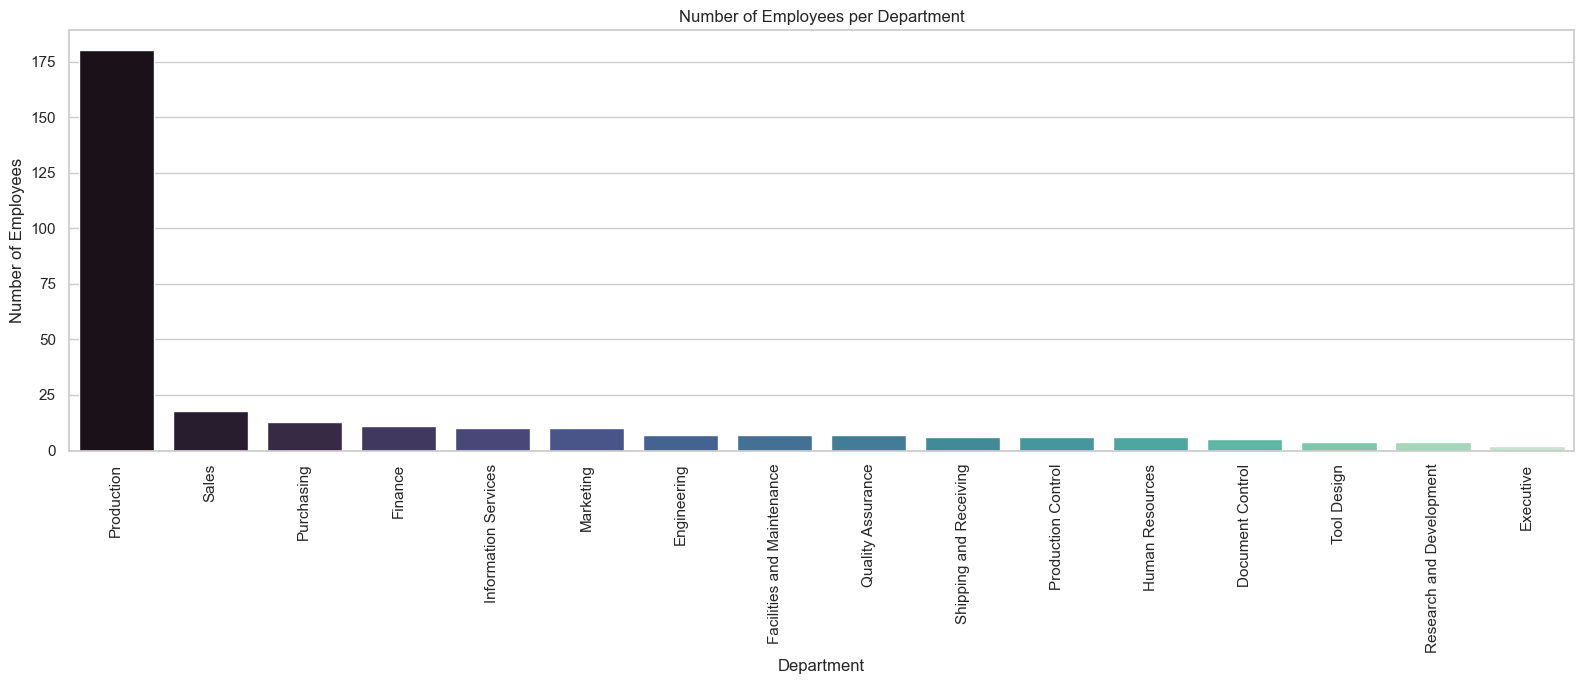

In [ ]:

# 4. Antal anställda per avdelning
query = """
SELECT d.Name AS DepartmentName, COUNT(e.BusinessEntityID) AS NumberOfEmployees
FROM HumanResources.EmployeeDepartmentHistory edh
JOIN HumanResources.Department d ON edh.DepartmentID = d.DepartmentID
JOIN HumanResources.Employee e ON edh.BusinessEntityID = e.BusinessEntityID
GROUP BY d.Name;
"""
df_employees_per_department = pd.read_sql(query_employees_per_department, engine)
# print(df_employees_per_department)

plt.figure(figsize=(16,7))  # Bredare bild
sns.barplot(
    data=df_employees_per_department.sort_values('NumberOfEmployees', ascending=False),
    x='DepartmentName',
    y='NumberOfEmployees',
    hue='DepartmentName',
    palette='mako',
    legend= False
)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0,5),
                textcoords='offset points')

plt.title('Number of Employees per Department')
plt.xlabel('Department')
plt.ylabel('Number of Employees')
plt.xticks(rotation=90)  # Roterar etiketter 90 grader
plt.tight_layout()
plt.show()


---

### About AdventureWorks2022
AdventureWorks is a fictional company that makes and sells bicycles and related accessories. The company operates in different areas like human resources, production, sales and customer management. Their database contains detailed information about employees, products, orders, and customers.

The product range mainly includes bikes, bike parts and accessories, showing that the company offers a wide variety for different customers segments. The database contains detailed employee data, a large product selection and tracks sales over time. 

---

### Overview of the Database Structure
The AdventureWorks2022 database is divided into several important schemas, each representing different parts of the business:

- **Production:** Contains data about manufacturing and products, including product details, categories and inventory management.

- **Sales:** Contains all sales transactions, customer orders, and financial data. 

- **Person:** Stores information about customers, contacts and personal details.

- **HumanResources:** Manages employee data, job titles, departments and other personnel information.

- **Purchasing:** Contains details about purchases, suppliers and purchase orders.

The database provides a solid foundation to analyze the company’s operations, workforce, product range and sales.

---

---

## Employee Data Overview

We look at the distribution of employees by job title to understand workforce structure.

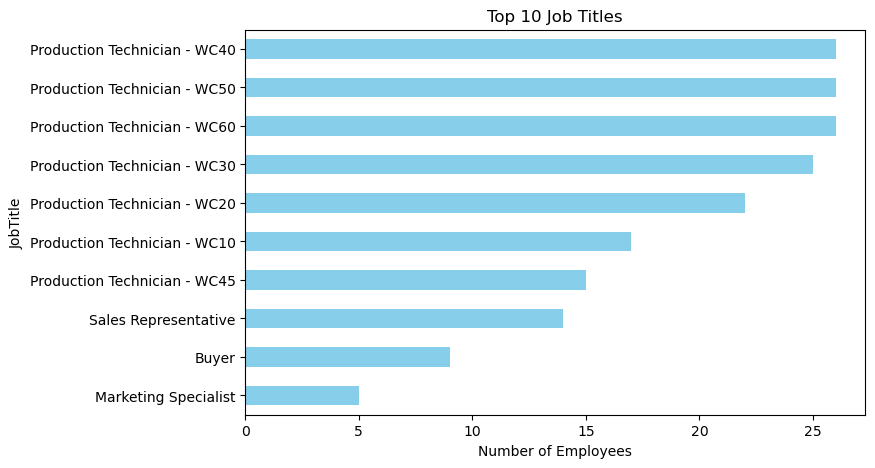

In [182]:
query_emp = "SELECT JobTitle FROM HumanResources.Employee"
df_emp = pd.read_sql(query_emp, connection)
emp_counts = df_emp['JobTitle'].value_counts()

plt.figure(figsize=(8,5))
emp_counts.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Job Titles")
plt.xlabel("Number of Employees")
plt.gca().invert_yaxis()
plt.show()


---

## Product Categories

Analyze product counts grouped by product category to understand the product portfolio.

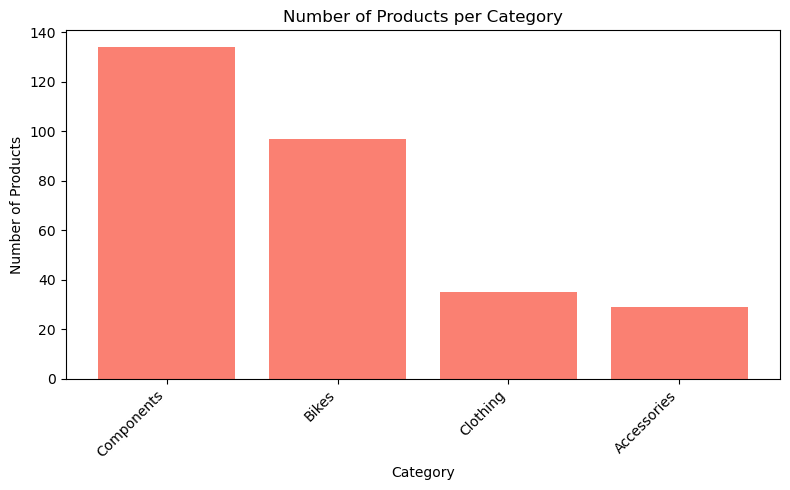

In [183]:
query_prod = """
SELECT pc.Name AS Category, COUNT(p.ProductID) AS ProductCount
FROM Production.Product AS p
JOIN Production.ProductSubcategory AS psc ON p.ProductSubcategoryID = psc.ProductSubcategoryID
JOIN Production.ProductCategory AS pc ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""
df_prod = pd.read_sql(query_prod, connection)

plt.figure(figsize=(8,5))
plt.bar(df_prod['Category'], df_prod['ProductCount'], color='salmon')
plt.title("Number of Products per Category")
plt.xlabel("Category")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


---

## Sales Trends Over Time

Check how the number of sales orders has changed yearly.

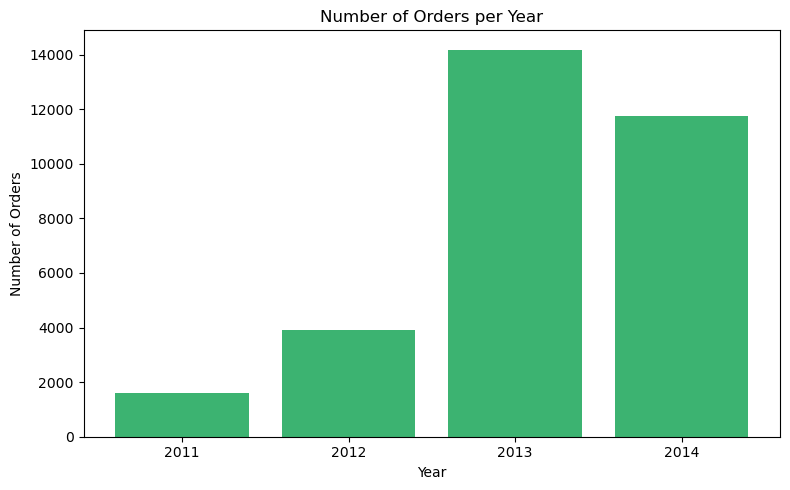

In [184]:
query_sales = """
SELECT YEAR(OrderDate) AS OrderYear, COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear
"""
df_sales = pd.read_sql(query_sales, connection)

plt.figure(figsize=(8,5))
plt.bar(df_sales['OrderYear'], df_sales['OrderCount'], color='mediumseagreen')
plt.title("Number of Orders per Year")
plt.xlabel("Year")
plt.ylabel("Number of Orders")
plt.xticks(df_sales['OrderYear'])
plt.tight_layout()
plt.show()


---

## Statistical Analysis of Order Values

Calculate the mean order value and a 95% confidence interval.

In [185]:
query = """
SELECT TotalDue
FROM Sales.SalesOrderHeader
WHERE TotalDue IS NOT NULL
"""
df_orders = pd.read_sql(query, con=connection)
df_orders.head()

,TotalDue
0,23153.2339
1,1457.3288
2,36865.8012
3,32474.9324
4,472.3108


In [186]:
data = df_orders['TotalDue'].values

mean = np.mean(data)
std_err = stats.sem(data)  # standard error of the mean
confidence = 0.95
n = len(data)

conf_int = stats.t.interval(confidence, df=n-1, loc=mean, scale=std_err)

print(f"Sample size: {n}")
print(f"Mean order value: {mean:.2f}")
print(f"95% confidence interval: ({conf_int[0]:.2f}, {conf_int[1]:.2f})")

Sample size: 31465
Mean order value: 3916.00
95% confidence interval: (3777.70, 4054.29)


---

## Statistical Analysis: Average Order Value

The sample size consists of 31465 orders with the mean total order value of approximately 3916.00 currency units.

The 95% confidence interval for the mean order value ranges from 3777.70 to 4054.29,
which means we are 95% confident that the true average order value lies within this interval.

This interval provides useful information for pricing and sales forecasting.

---

## Conclusions and Recommendations

- The employee data shows a workforce with many production technicians, indicating a manufacturing focus.  
- Product categories are dominated by 'Components' and 'Bikes', likely core product lines.  
- Sales orders increased steadily from 2011 to 2013 with a slight dip in 2014, possibly reflecting market trends or seasonality.  
- The average order value is stable with a tight 95% confidence interval, useful for forecasting and planning.  

Recommendations include customer segmentation, seasonal sales analysis, and continuous monitoring of sales to respond quickly to market changes.

---

## Executive Summary

This analysis of AdventureWorks2022 reveals key insights into workforce composition, product portfolio, and sales trends. Production technicians dominate the workforce, with products concentrated in core categories. Sales trends indicate growth followed by slight declines, and the average order value is statistically stable. These findings support targeted business decisions for marketing, inventory, and forecasting.

---